In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [11]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "images/lada_dataset",
    shuffle = True,
    follow_links=True,
    batch_size = BATCH_SIZE
)

Found 2649 files belonging to 31 classes.


In [12]:
class_names = dataset.class_names
len(class_names)

31

In [13]:
len(dataset)

83

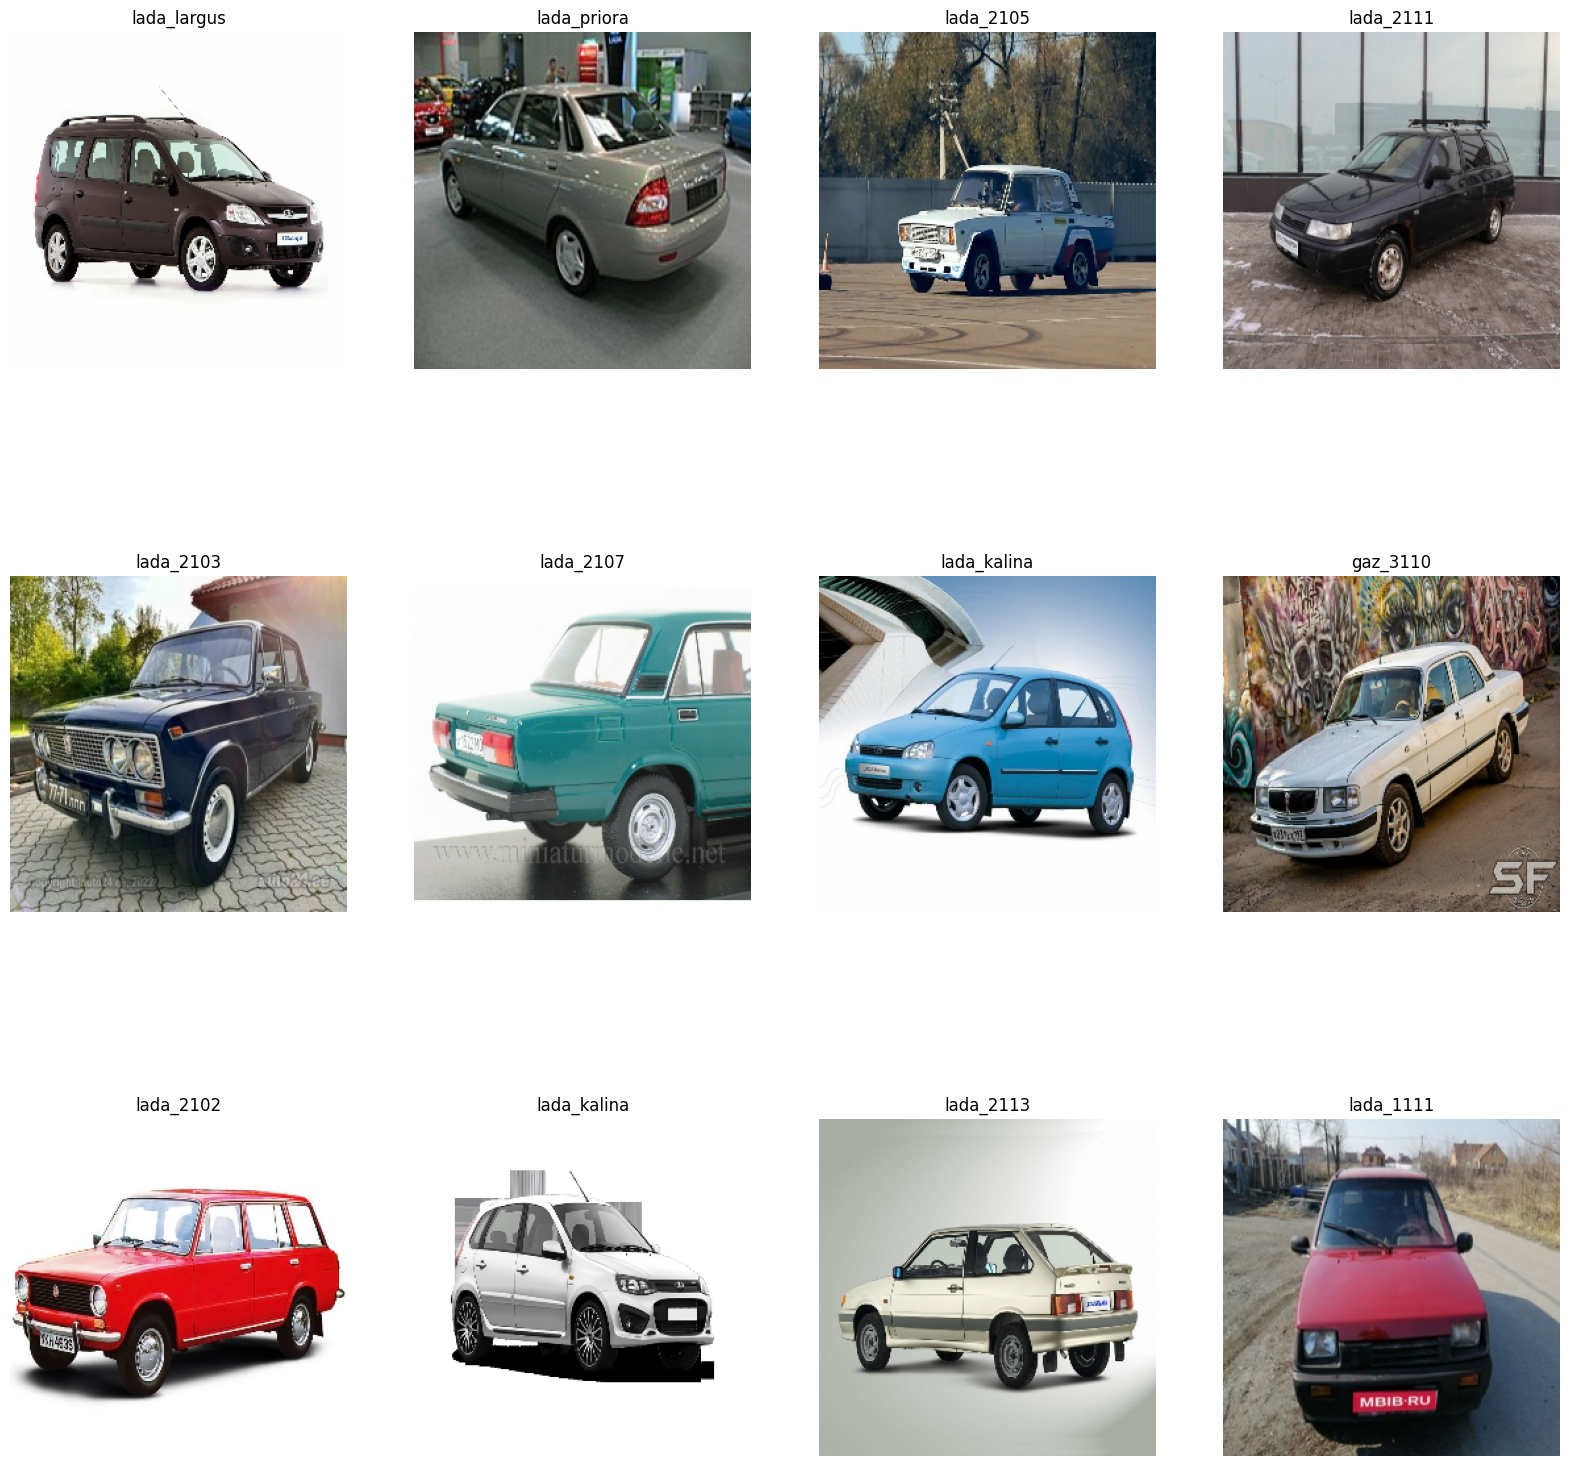

In [14]:
plt.figure(figsize=(20, 20))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [15]:
len(dataset)

83

In [16]:
train_size = 0.8
len(dataset)*train_size

66.4

In [17]:
train_ds = dataset.take(int(len(dataset)*train_size))
len(train_ds)

66

In [18]:
test_ds = dataset.skip(int(len(dataset)*train_size))
len(test_ds)

17

In [19]:
val_size = 0.1
len(dataset)*val_size

8.3

In [20]:
val_ds = test_ds.take(int(len(dataset)*val_size))
len(val_ds)

8

In [21]:
test_ds = test_ds.skip(int(len(dataset)*val_size))
len(test_ds)

9

In [22]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [23]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [24]:
len(train_ds)

66

In [25]:
len(val_ds)

8

In [26]:
len(test_ds)

9

In [27]:
train_ds = train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)

In [28]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [29]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [32]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

model = models.Sequential([
    # resizing & rescaling + flip & rotation
    resize_and_rescale,
    data_augmentation,
    
    # cnn
    layers.Conv2D(filters = 32, kernel_size = (3, 3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters = 64, kernel_size = (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters = 64, kernel_size = (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters = 64, kernel_size = (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters = 64, kernel_size = (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters = 64, kernel_size = (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # dense
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape = input_shape)

In [33]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [34]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [35]:
history = model.fit(
    train_ds,
    epochs=30,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/30
66/66 [==============================] - 102s 1s/step - loss: 3.4360 - accuracy: 0.0304 - val_loss: 3.4349 - val_accuracy: 0.0195
Epoch 2/30
66/66 [==============================] - 77s 1s/step - loss: 3.4355 - accuracy: 0.0347 - val_loss: 3.4345 - val_accuracy: 0.0430
Epoch 3/30
66/66 [==============================] - 84s 1s/step - loss: 3.4336 - accuracy: 0.0299 - val_loss: 3.4337 - val_accuracy: 0.0352
Epoch 4/30
66/66 [==============================] - 73s 1s/step - loss: 3.4333 - accuracy: 0.0318 - val_loss: 3.4343 - val_accuracy: 0.0352
Epoch 5/30
66/66 [==============================] - 76s 1s/step - loss: 3.4304 - accuracy: 0.0328 - val_loss: 3.4231 - val_accuracy: 0.0273
Epoch 6/30
66/66 [==============================] - 72s 1s/step - loss: 3.4032 - accuracy: 0.0342 - val_loss: 3.3947 - val_accuracy: 0.0273
Epoch 7/30
66/66 [==============================] - 68s 1s/step - loss: 3.3755 - accuracy: 0.0499 - val_loss: 3.3251 - val_accuracy: 0.0742
Epoch 8/30
66/66 [=

KeyboardInterrupt: 

In [35]:
scores = model.evaluate(test_ds)

9/9 [==============================] - 3s 280ms/step - loss: 3.3290 - accuracy: 0.7986


In [36]:
scores

[3.3290319442749023, 0.7986111044883728]

In [38]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 66}

In [40]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [41]:
history.history['accuracy']

[0.03279467672109604,
 0.030893536284565926,
 0.055608365684747696,
 0.06749049574136734,
 0.08222433179616928,
 0.11929658055305481,
 0.1359315663576126,
 0.17538022994995117,
 0.20389734208583832,
 0.25190114974975586,
 0.29515209794044495,
 0.35598859190940857,
 0.40731939673423767,
 0.48811787366867065,
 0.5423004031181335,
 0.6478136777877808,
 0.6863117814064026,
 0.73384028673172,
 0.8051331043243408,
 0.7590304017066956,
 0.8307985067367554,
 0.9054182767868042,
 0.9006654024124146,
 0.9158745408058167,
 0.9096958041191101,
 0.947718620300293,
 0.9524714946746826,
 0.9515209197998047,
 0.8479087352752686,
 0.928231954574585,
 0.9691064357757568,
 0.9610266089439392,
 0.9686312079429626,
 0.9795627593994141,
 0.9714828729629517,
 0.9762357473373413,
 0.9439163208007812,
 0.9363117814064026,
 0.983364999294281,
 0.980513334274292,
 0.9824144244194031,
 0.983364999294281,
 0.9662547707557678,
 0.9500950574874878,
 0.9534220695495605,
 0.9672053456306458,
 0.9866920113563538,
 0.99

In [42]:
loss = history.history['loss']
acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

Text(0.5, 1.0, 'training and validation accuracy')

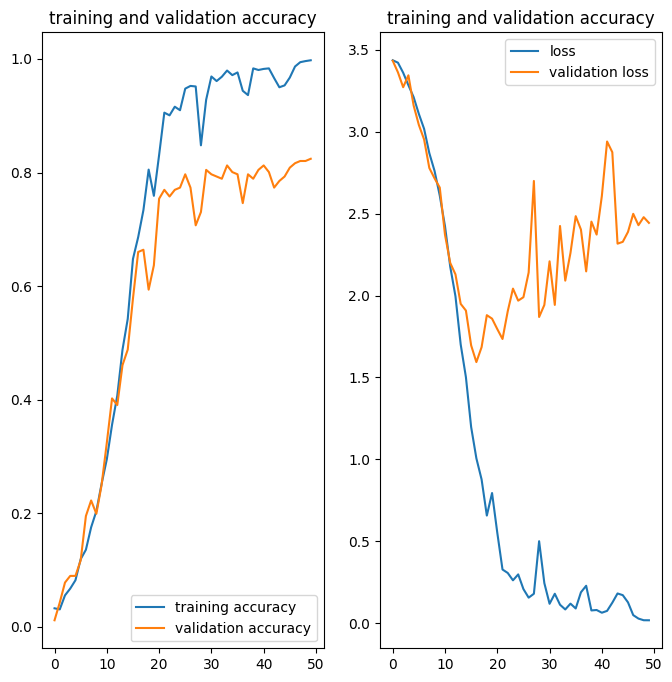

In [48]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='training accuracy')
plt.plot(range(EPOCHS), val_accuracy, label='validation accuracy')
plt.legend(loc='lower right')
plt.title('training and validation accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='loss')
plt.plot(range(EPOCHS), val_loss, label='validation loss')
plt.legend(loc='upper right')
plt.title('training and validation accuracy')

first image_s actual label: lada_2108
predicted label: lada_2108


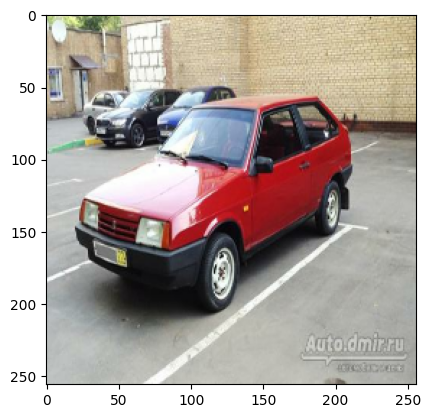

In [79]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    plt.imshow(first_image)
    print(f'first image_s actual label: {class_names[first_label]}')
    
    batch_prediction = model.predict(images_batch, verbose=0)
    print(f'predicted label: {class_names[np.argmax(batch_prediction[0])]}')

In [87]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # create a batch
    
    predictions = model.predict(img_array, verbose=0)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

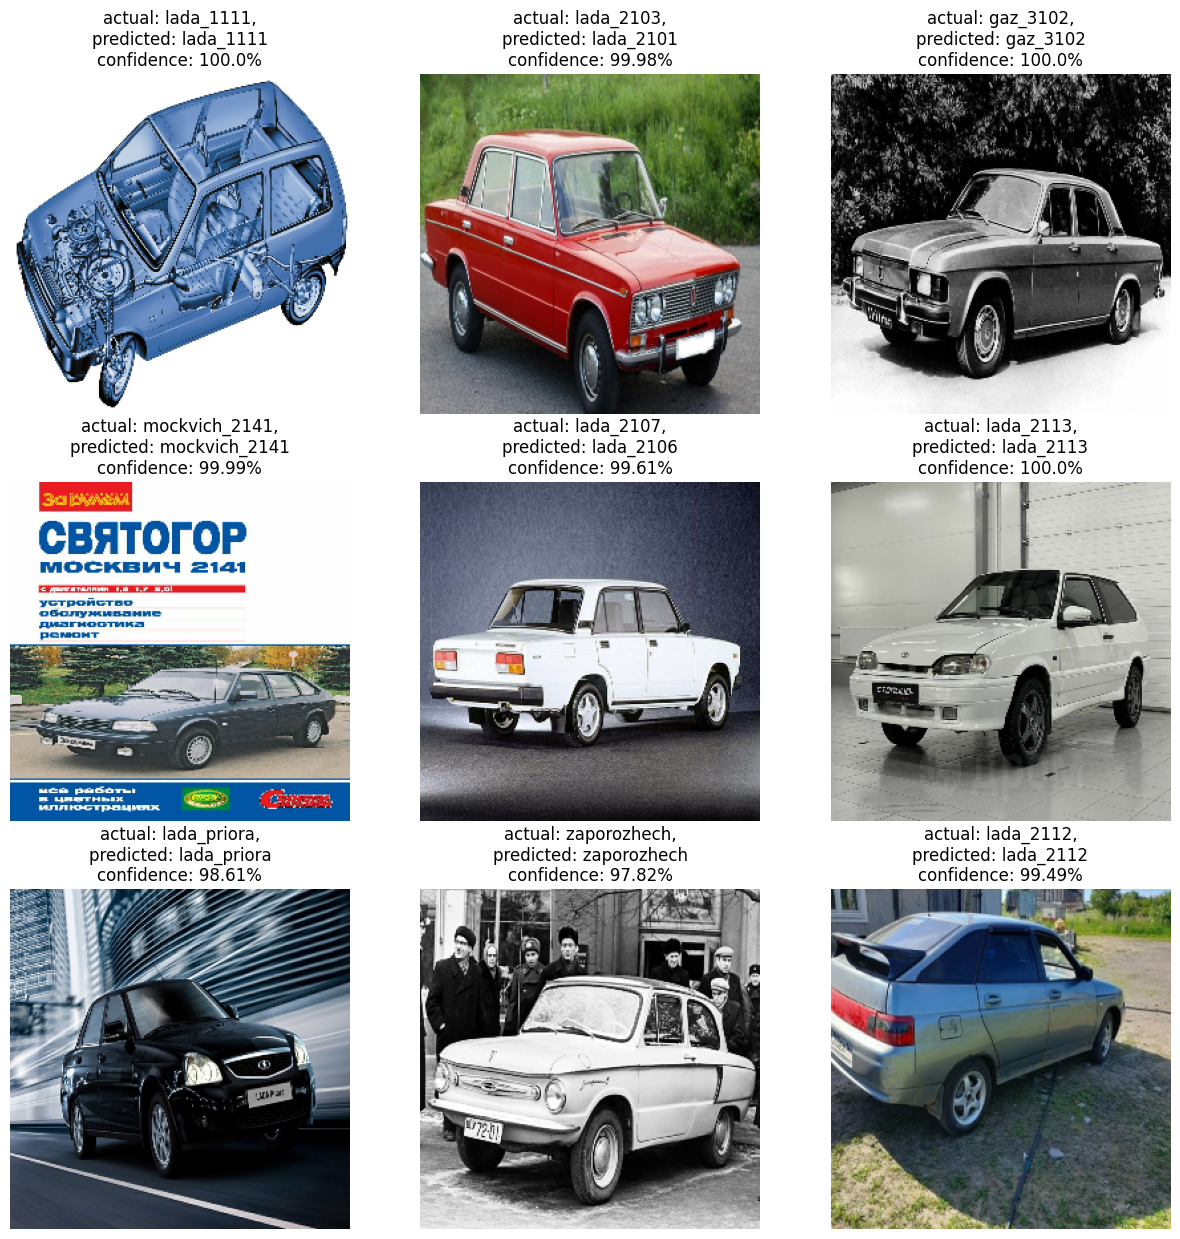

In [88]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f'actual: {actual_class},\npredicted: {predicted_class}\nconfidence: {confidence}%')
        plt.axis('off')

In [ ]:
import os
model_version = max([int(i) for i in os.list])